# Brain Tumor Detection 

A brain tumor is a mass or growth of abnormal cells in your brain.
Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain (secondary, or metastatic, brain tumors).

How quickly a brain tumor grows can vary greatly. The growth rate as well as location of a brain tumor determines how it will affect the function of your nervous system.

Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.

**The aim of this notebook is to classify MRI images of the brain for tumor and tumorless images. The data source for this data is https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection. We explored different models and tried to find the best fit. The dataset contains 155 images of tumor images and 98 images of tumor-less images.**

Previous EDA had been done using pre-trained models on this dataset. But we tried constructing a novel model and later compared it with a pre-trained model. 


**Setting up the environment**

Importing all the required libraries and modules.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from google.colab import files

from io import BytesIO
from zipfile import ZipFile

from random import shuffle 

from skimage.transform import rotate, AffineTransform, warp
import skimage.io as io
import torchvision.models as models
import matplotlib.image as mpimg

<ipython-input-1-bc4f0cb920e8>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
uploaded = files.upload()

Saving archive.zip to archive.zip


Extracting the files from the zip file.

In [4]:
zipfile = ZipFile('/content/archive.zip')
zipfile.extractall(path = './brainMriImages')

Initially, we displayed a few images to see the shape of images in our dataset.  

<ipython-input-5-ee0c88088355>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imread('/content/brainMriImages/brain_tumor_dataset/no/10 no.jpg')[:,:]


(201, 173, 3)


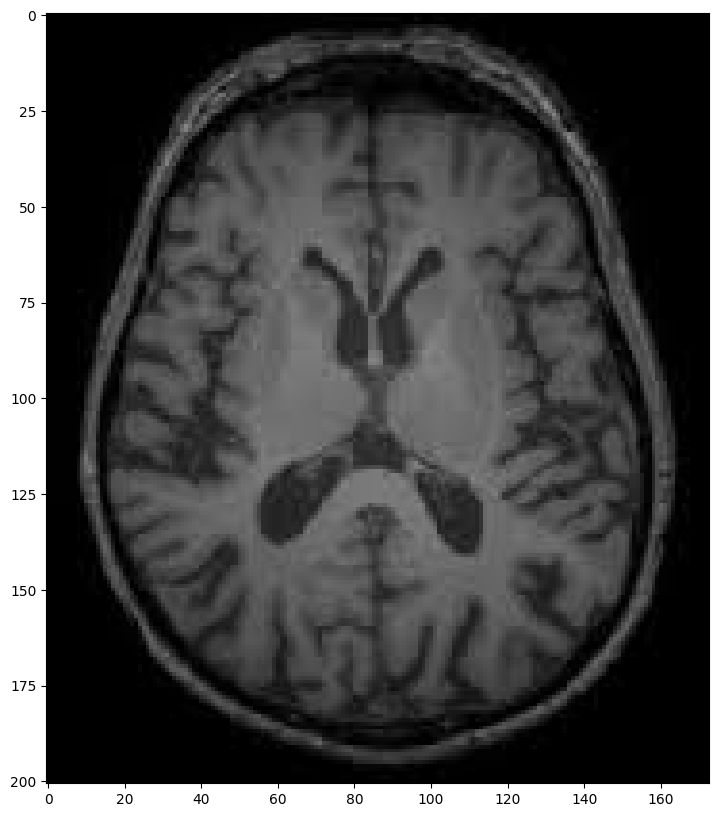

In [5]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/no/10 no.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

The above image had 3 channels but the below image did'nt have any channels.

<ipython-input-6-c408849958cf>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imread('/content/brainMriImages/brain_tumor_dataset/no/1 no.jpeg')[:,:]


(630, 630)


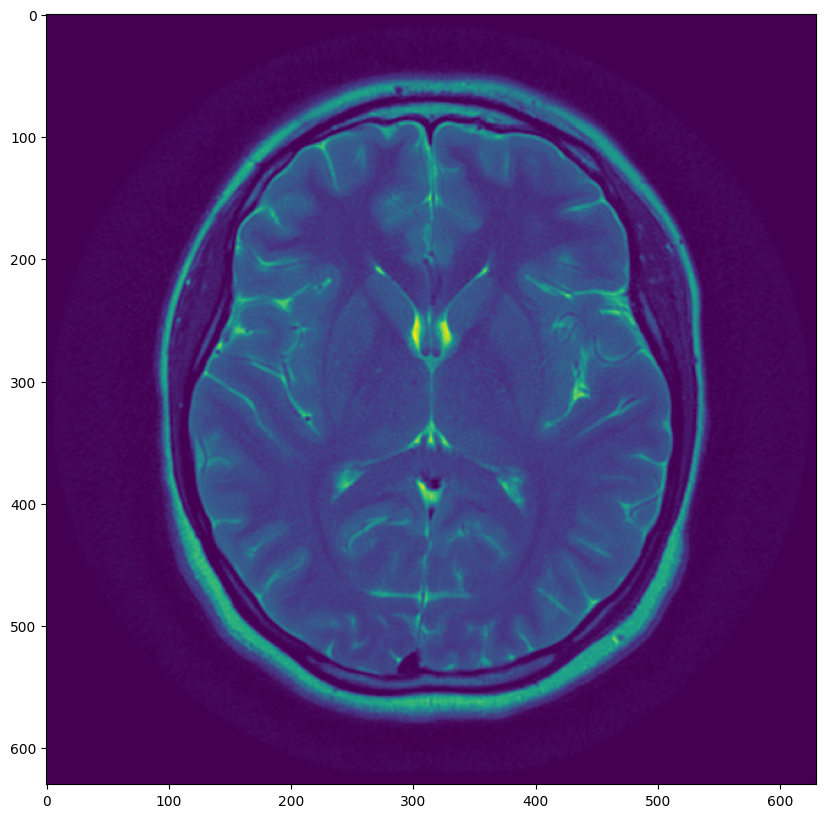

In [6]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/no/1 no.jpeg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

<ipython-input-7-74aeba98870c>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y1.jpg')[:,:,0]


(218, 180)


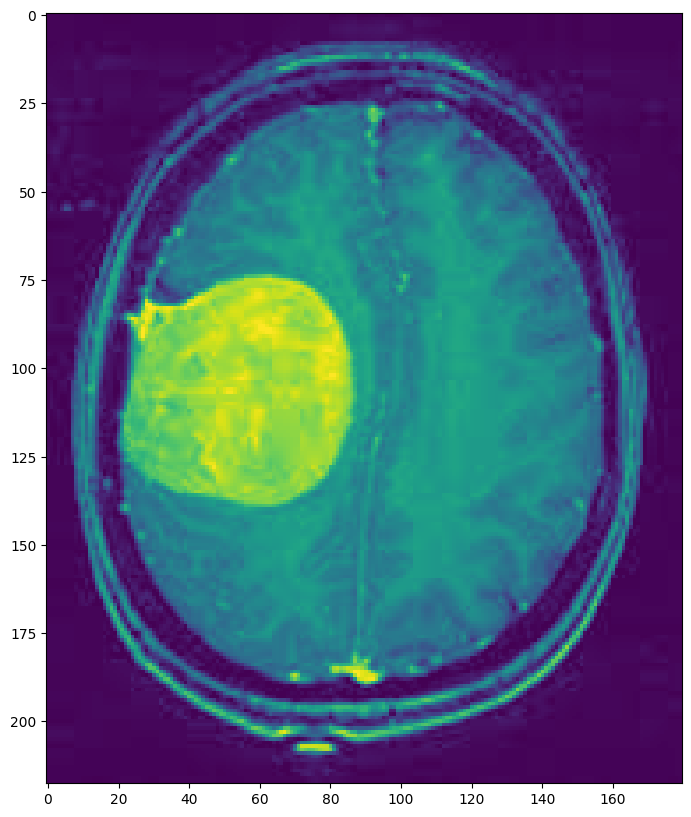

In [7]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y1.jpg')[:,:,0]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

<ipython-input-8-18389f360e6f>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y10.jpg')[:,:]


(360, 319)


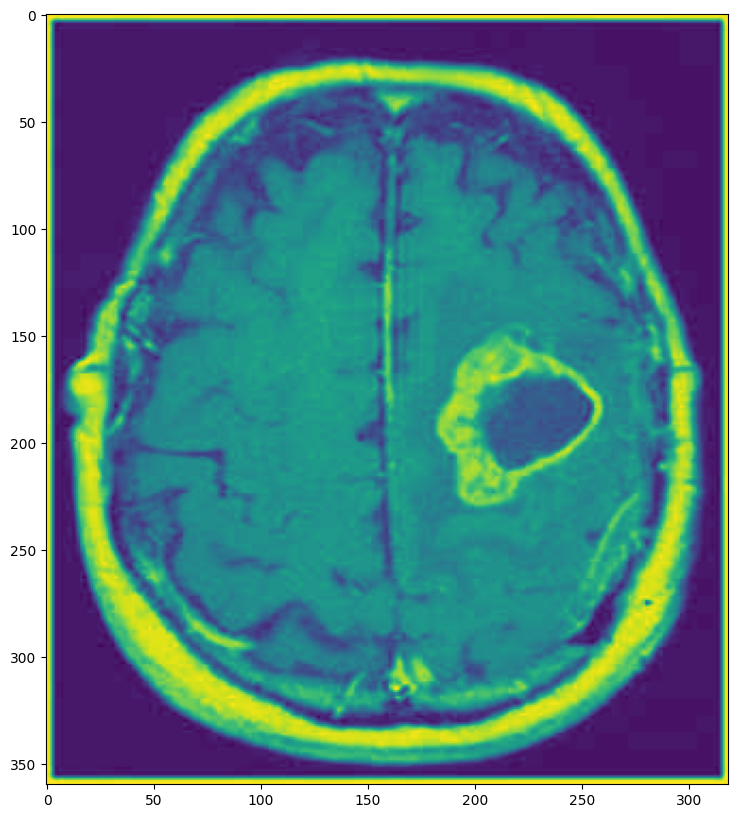

In [8]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y10.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

To extract all images in the file path 'no', we used the glob function.

In [9]:
images= glob('/content/brainMriImages/brain_tumor_dataset/no/*')

In [10]:
images

['/content/brainMriImages/brain_tumor_dataset/no/50 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/11 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 1.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 89.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No19.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/7 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 7.jpeg',
 '/content/brainMriImages/brain_tumor_dataset/no/N17.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No18.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/47 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No16.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 95.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 2.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/N20.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/N6.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/19 no.jpg',
 '/content/brainMriImages/brain_tumor

To extract all images in the file path 'yes', we used the glob function. We combined both the yes and no images together.

In [11]:
images=images+glob('/content/brainMriImages/brain_tumor_dataset/yes/*')

In [12]:
images

['/content/brainMriImages/brain_tumor_dataset/no/50 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/11 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 1.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 89.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No19.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/7 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 7.jpeg',
 '/content/brainMriImages/brain_tumor_dataset/no/N17.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No18.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/47 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/No16.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 95.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 2.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/N20.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/N6.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/19 no.jpg',
 '/content/brainMriImages/brain_tumor

We shuffled the images for randomness.

In [13]:
shuffle(images)

In [14]:
images

['/content/brainMriImages/brain_tumor_dataset/no/no 2.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/37 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y244.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y258.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y23.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y249.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/7 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y161.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y167.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/No16.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 4.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 98.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/no 94.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y54.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y2.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y154.jpg',
 '/content/brainMriImages/brain_

We checked the shape of every image and found every image do be of differnet size and shape. There are cases where an image had 3 channels, 4 channels and no channels. There were even cases where channels existed at a different position. For modeling we need to make sure that every image is same size

In [15]:
for i in images:
  print(imread(i).shape)

<ipython-input-15-3fbdcf7e110a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  print(imread(i).shape)


(217, 232, 3)
(225, 225, 3)
(351, 278, 3)
(349, 292, 3)
(277, 272, 3)
(331, 260, 3)
(417, 428, 3)
(351, 273, 3)
(350, 272, 3)
(200, 300, 3)
(275, 220)
(725, 728)
(630, 630)
(325, 300)
(212, 209, 3)
(431, 400, 3)
(318, 273, 3)
(366, 310, 3)
(282, 230, 3)
(225, 225, 3)
(1080, 1920, 3)
(225, 225, 3)
(442, 442)
(442, 400, 3)
(231, 218, 3)
(225, 225, 3)
(630, 630, 3)
(340, 314, 3)
(380, 310, 3)
(442, 442, 3)
(630, 587, 3)
(308, 244, 3)
(442, 441, 3)
(243, 207, 3)
(242, 208, 3)
(442, 353, 3)
(449, 359, 3)
(1200, 1059, 3)
(630, 630, 3)
(442, 442)
(326, 276, 3)
(929, 634, 3)
(4, 454, 442)
(4, 400, 393)
(444, 468, 3)
(248, 208, 3)
(251, 201, 3)
(360, 319)
(340, 339, 3)
(234, 215, 3)
(246, 205, 3)
(750, 750)
(342, 273, 3)
(251, 201, 3)
(337, 293, 3)
(218, 180, 3)
(247, 204, 3)
(355, 310, 3)
(349, 278, 3)
(257, 196, 3)
(225, 225, 3)
(1024, 1024)
(349, 300, 3)
(294, 250)
(879, 766, 3)
(380, 310, 3)
(380, 294, 3)
(348, 297, 3)
(393, 350, 3)
(249, 178, 3)
(290, 250, 3)
(354, 303, 3)
(334, 283, 3)
(1

Extracting images which had 4 channels at the first position in shape.

In [16]:
for i in images:
  if(imread(i).shape[0]==4):
    print(i)

<ipython-input-16-6218642a1be1>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if(imread(i).shape[0]==4):


/content/brainMriImages/brain_tumor_dataset/no/No18.jpg
/content/brainMriImages/brain_tumor_dataset/no/No15.jpg
/content/brainMriImages/brain_tumor_dataset/no/No17.jpg
/content/brainMriImages/brain_tumor_dataset/no/no.jpg
/content/brainMriImages/brain_tumor_dataset/no/no 96.jpg


<ipython-input-17-85a70de92ee6>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imread('/content/brainMriImages/brain_tumor_dataset/no/No17.jpg')


torch.Size([4, 400, 393])
torch.Size([1, 4, 512, 512])


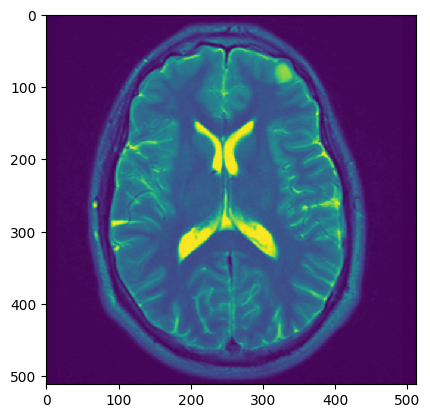

In [17]:
img=imread('/content/brainMriImages/brain_tumor_dataset/no/No17.jpg')

img=img/255.0           # to convert RGB images which are in range [0,255] to [0.0,1.0]
img=torch.tensor(img)   # converting numpy array into tensor object
print(img.shape)
img=img.unsqueeze(0)    # adding a new dimension by filling with zero's
img = F.interpolate(img, (512, 512))  # Down/up samples the input to either the given size or the given scale_factor 
print(img.shape)
imgplot = plt.imshow(img[0,0,:,:]) # displaying the image using imshow() function
plt.show()


In [18]:
img.shape

torch.Size([1, 4, 512, 512])

Creating a BrainImages object.

In [19]:
class BrainImages(Dataset):
  
  def __init__(self, paths):
      self.paths = paths
  
  
  def __len__(self):
      return len(self.paths)
  
  
  def __getitem__(self, index):
      image_path = self.paths[index]
      if 'yes' in image_path:
        cls=1                           # Assiging labels to each image based on their path. yes is given a class '1' and no is '0'
      else:
        cls=0 

      if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
        img=imread(image_path)
        img=np.moveaxis(img,0,-1)   #shifting element at poisition 0 to -1 (4,255,255---> 255,255,4)
        img=img[:,:,0]              # nulling the element at position -1 (255,255)
      elif len(imread(image_path).shape)==3:
        img=imread(image_path)[:,:,0]
      else:
        img=imread(image_path)
      

      img=img/255.0                # to convert RGB images which are in range [0,255] to [0.0,1.0]
      #img=img.astype('float')
      
      img=torch.tensor(img)        # converting numpy array to tensor
      #img=img.type(torch.cuda.FloatTensor)
      img=img.unsqueeze(0)         # adding a new dimension for channel 
      img = F.interpolate(img.unsqueeze(0), (224, 224))  # Down/up samples the input to either the given size or the given scale_factor.
      dim = np.zeros((224,224))     # Since we want to comapre our novel model with a pre-trained model which accepts 3 channels as input,
      R = np.stack((img[0,0,:],dim, dim), axis=0) #we are adding 2 extra channels.
      
      return (R,cls)

In [20]:
paths=images

In [21]:
data = BrainImages(paths)

In [22]:
len(data)  # To verify all our images from the dataset have been extracted, labelled with correct class and converted to required shape.

253

Total number of images from the dataset is 155 yes + 98 No = 253


Making sure our images have the desired shape of (Channels=3,width=224, height=224)

Width and Height values were chosen based on requirements for pre-trained model. 

In [23]:
data[0][0].shape

<ipython-input-19-bce9d8e67e6d>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
<ipython-input-19-bce9d8e67e6d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  elif len(imread(image_path).shape)==3:
<ipython-input-19-bce9d8e67e6d>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as

(3, 224, 224)

### Data Augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

There happen to exist a number of ways to augment data. We chose a few techniques like rotate (rotates the image at a given angle), AffineTransformfrom (transformation preserving collinearity) and warp (warps the image) using the **skimage.transform** module.

Checking out how the rotate technique works on the image.

<ipython-input-19-bce9d8e67e6d>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
<ipython-input-19-bce9d8e67e6d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  elif len(imread(image_path).shape)==3:
<ipython-input-19-bce9d8e67e6d>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as

(3, 224, 224)


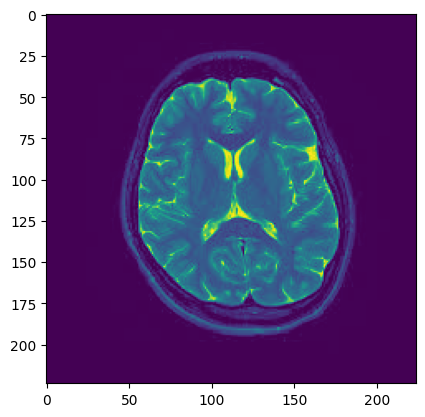

(224, 224)


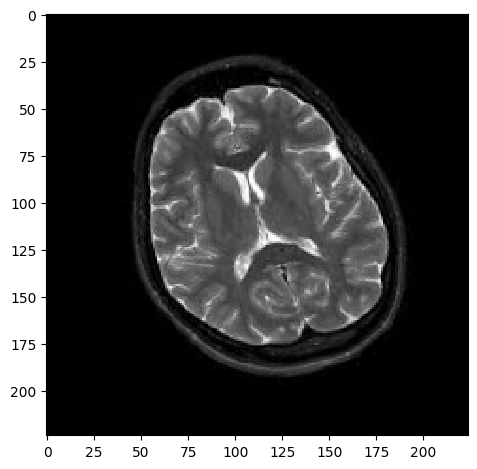

In [24]:
print(data[0][0].shape)
imgplot = plt.imshow(data[0][0][0,:])
plt.show()
rotated = rotate(data[0][0][0,:], angle=15, mode = 'wrap')
 #plot the rotated 
print(rotated.shape)
io.imshow(rotated)

From the above example, after rotating an image, the shape of the image is changing from (3,224,224) to (224,224). Hence, it is imperative that we add new dimensions after transforming our image.


Creating a list of images after they are applied all the transformations(wrap shifting,rotations). 

In [25]:
rotated_images = []
for i in range(len(data)):
  for j in range(5,35,5):     # We want images at angles 10,15,20,25,30,35
    rotated_left = rotate(data[i][0][0,:], angle=j, mode = 'wrap')   # rotating each image at a respective angle
    rotated_left_tensor=torch.tensor(rotated_left) #.type(torch.DoubleTensor)  #converting array into a tensor
    transform = AffineTransform(translation=(25,25))      # Applying affine transform
    wrapShift = warp(data[i][0][0,:],transform,mode='wrap')  #applying warp transform
    rotated_images.append((torch.tensor(wrapShift).unsqueeze(0),data[i][1])) # adding a new dimension for channel
    rotated_images.append((rotated_left_tensor.unsqueeze(0),data[i][1])) #adding a new dimension for channel
    rotated_right = rotate(data[i][0][0,:], angle=-j, mode = 'wrap') # for opposite angle rotation.
    rotated_right_tensor=torch.tensor(rotated_right) 
    rotated_images.append((rotated_right_tensor.unsqueeze(0),data[i][1]))   # adding a new dimension for channel.
    


<ipython-input-19-bce9d8e67e6d>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
<ipython-input-19-bce9d8e67e6d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  elif len(imread(image_path).shape)==3:
<ipython-input-19-bce9d8e67e6d>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as

Checking how our transformed image looks.

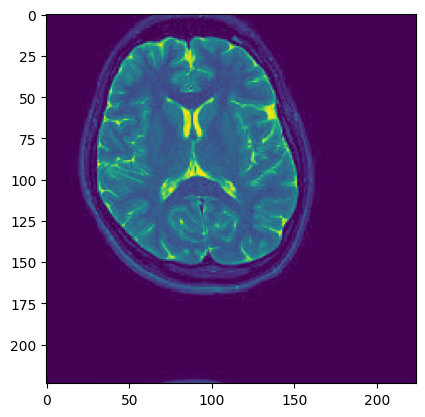

In [26]:
rotated_images[0][0][0,:]

imgplot = plt.imshow(rotated_images[0][0][0,:])

plt.show()

Adding 2 channels which is required input format for pre-trained model.

In [27]:
rotated_3channel =[]
for rotatedimages in rotated_images:
      dim = np.zeros((224,224))   # arrays with zero's
   
      R = np.stack((rotatedimages[0][0,:],dim, dim), axis=0) # adding new channels using stack
      rotated_3channel.append((R,rotatedimages[1]))

(3, 224, 224)


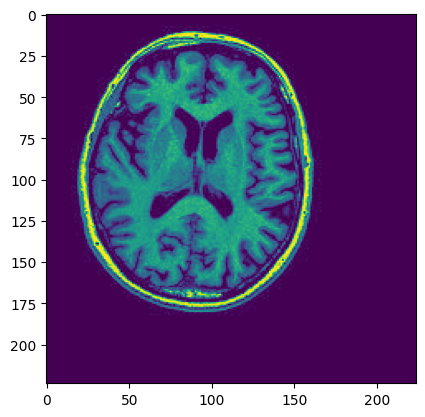

In [28]:
print(rotated_3channel[21][0].shape)
imgplot = plt.imshow(rotated_3channel[21][0][0,:])
plt.show()

In [29]:
del rotated_images

Adding the data from dataset (data) and augmented data.

In [30]:
data=data + rotated_3channel

In [31]:
del rotated_3channel

Now, we converted the input data to float tensors and appended corresponding target values.

In [32]:
float_tensors = []
for image in range(len(data)):
  float_tensors.append((torch.tensor(data[image][0]).type(torch.cuda.FloatTensor),data[image][1]))

<ipython-input-19-bce9d8e67e6d>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
<ipython-input-19-bce9d8e67e6d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  elif len(imread(image_path).shape)==3:
<ipython-input-19-bce9d8e67e6d>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as

In [33]:
del data #clearing it from memory

In [34]:
len(float_tensors) # total number of images for our training, validation and testing.

4807

Dispaying a sample image from the entire dataset

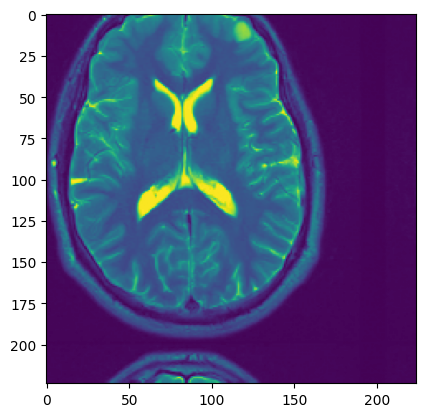

In [35]:
float_tensors[2015][0][0,:].shape
imgplot = plt.imshow(float_tensors[2005][0][0,:].cpu())

plt.show()

Splitting the dataset into training and testing sets.

We have given 3500 images to training and 1307 images for testing.

In [36]:
train_split, test_split = torch.utils.data.random_split(float_tensors, [3500, len(float_tensors)-3500])

Defining the training and testing loaders.

In [37]:
train_loader = DataLoader(train_split, batch_size=1, shuffle=True)
test_loader = DataLoader(test_split, batch_size=1, shuffle=True)

We used a few functions from previous lectures for training our model.

In [38]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [39]:
def weight_reset(m):
    """
    Go through a PyTorch module m and reset all the weights to an initial random state
    """
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

In [40]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [41]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [42]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


In [43]:
D = 32
hidden_nodes = 64
classes = 2

Defining our first network. We used a fully connected network.

In [44]:
first_linear= nn.Sequential(
    nn.Flatten(),
    nn.Linear(150528,hidden_nodes),
    nn.LeakyReLU(),
    nn.Linear(hidden_nodes,hidden_nodes),
    nn.LeakyReLU(),
    nn.Linear(hidden_nodes,2)
)

In [45]:
first_linear.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=64, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=64, out_features=2, bias=True)
)

In [46]:
loss_func = nn.CrossEntropyLoss()

In [47]:
linear_model = train_simple_network(first_linear, loss_func, train_loader, val_loader= test_loader,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

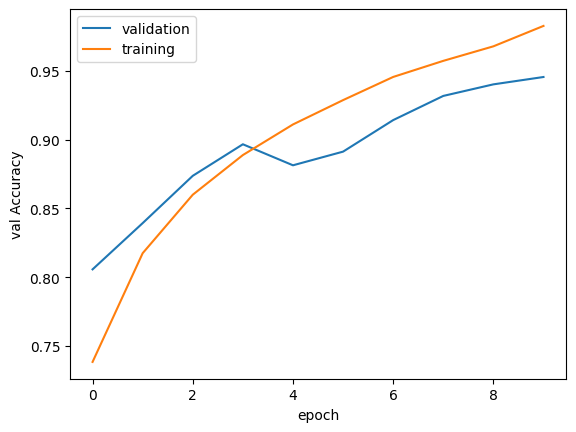

In [48]:
sns.lineplot(x='epoch', y='val Accuracy', data=linear_model, label='validation')
sns.lineplot(x='epoch', y='train Accuracy', data=linear_model, label='training')

The model performed pretty well with both training and validation accuracies surging past 95 % after 10 epochs. 

We also visualized the validation loss to understand how the model learnt from each epoch.

<Axes: xlabel='epoch', ylabel='val loss'>

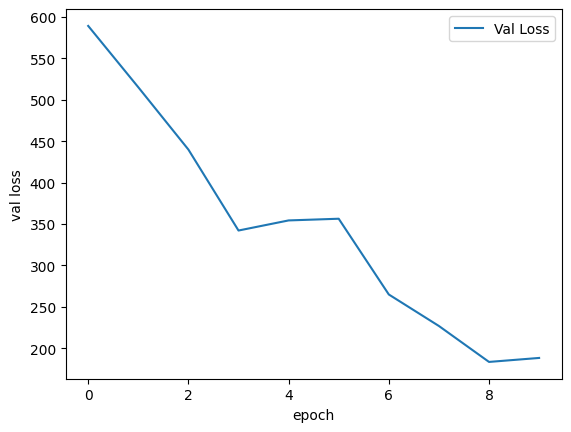

In [49]:
sns.lineplot(x='epoch', y='val loss', data=linear_model, label='Val Loss')

Our next model is a small convolution network.

In [50]:
first_cnn= nn.Sequential(
    nn.Conv2d(3,D,3,padding=1),
    nn.ReLU(),
    nn.Conv2d(32,1,(3),padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(224*224,2),
    
    )

In [51]:
first_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten()
  (5): Linear(in_features=50176, out_features=2, bias=True)
)

In [52]:
loss_func = nn.CrossEntropyLoss()

In [53]:
batch_one_train = train_simple_network(first_cnn, loss_func, train_loader, val_loader= test_loader,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

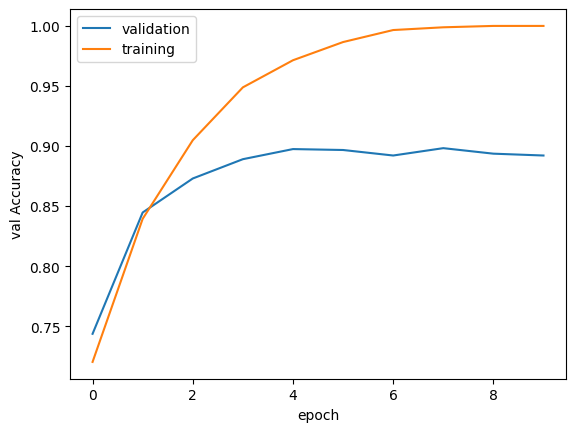

In [54]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='validation')
sns.lineplot(x='epoch', y='train Accuracy', data=batch_one_train, label='training')

From the above results, the model performed well with validation accuracy reaching around **90%** after 10 epochs.

Also visualizing the validation loss, after the 5th epoch, the model struggled to rightly predict an image.

<Axes: xlabel='epoch', ylabel='val loss'>

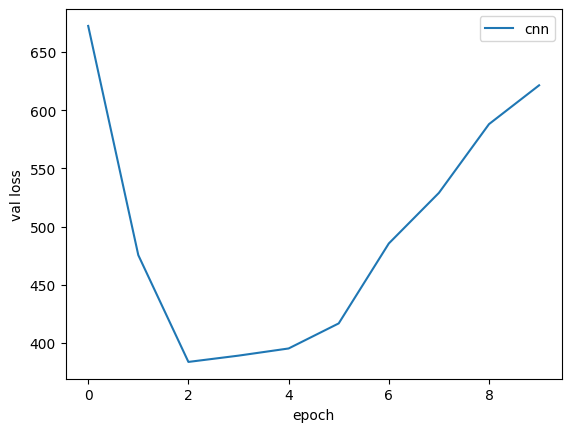

In [55]:
sns.lineplot(x='epoch', y='val loss', data=batch_one_train, label='cnn')

We hoped a network with more layers and batch normalization would bring better results.

In [56]:
second_cnn= nn.Sequential(
    nn.Conv2d(3,D,3,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(D),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    Flatten(),
    nn.Linear(1605632,2),
    
    )

In [57]:
second_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Flatten()
  (13): Linear(in_features=1605632, out_features=2, bias=True)
)

In [58]:
batch_two_train = train_simple_network(second_cnn, loss_func, train_loader, val_loader= test_loader,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

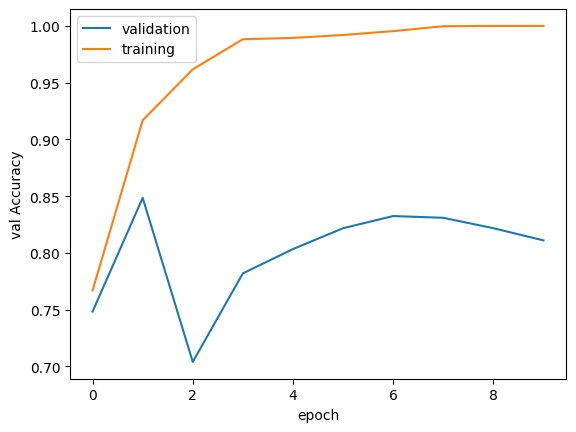

In [59]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_two_train, label='validation')
sns.lineplot(x='epoch', y='train Accuracy', data=batch_two_train, label='training')

The model couldn't outperform the previous CNN model. We visualized the validation loss which turned out be worse than the previous case.

<Axes: xlabel='epoch', ylabel='val loss'>

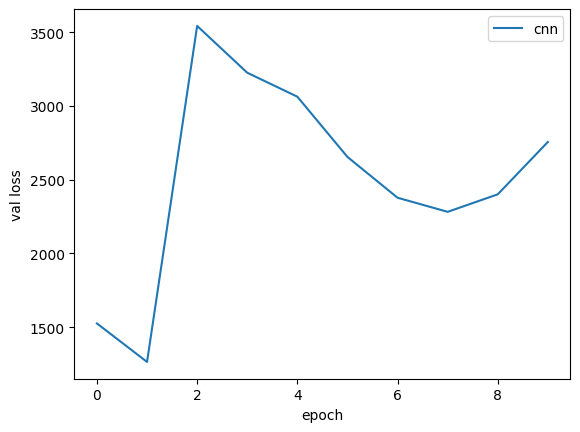

In [60]:
sns.lineplot(x='epoch', y='val loss', data=batch_two_train, label='cnn')

We believed that we could try a different normalization tehchnique and achieve a better performance. So we employed the LayerNorm() technique in place of the previously used BatchNorm2D.

In [61]:
out_shape = (3, 224, 224)
width_height = (out_shape[-2], out_shape[-1])
third_cnn= nn.Sequential(
    View(-1, 3,out_shape[-2], out_shape[-1]),
    nn.Conv2d(3,D,3,padding=1),
    nn.ReLU(),
    nn.LayerNorm(width_height),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.LayerNorm(width_height),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.LayerNorm(width_height),
    nn.Conv2d(32,32,(3),padding=1),
    nn.ReLU(),
    nn.LayerNorm(width_height),
    nn.Flatten(),
    nn.Linear(1605632,2),
    
    )

In [62]:
third_cnn.to(device)

Sequential(
  (0): View()
  (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): LayerNorm((224, 224), eps=1e-05, elementwise_affine=True)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): LayerNorm((224, 224), eps=1e-05, elementwise_affine=True)
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): LayerNorm((224, 224), eps=1e-05, elementwise_affine=True)
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): LayerNorm((224, 224), eps=1e-05, elementwise_affine=True)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1605632, out_features=2, bias=True)
)

In [63]:
batch_three_train = train_simple_network(third_cnn, loss_func, train_loader, val_loader= test_loader,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

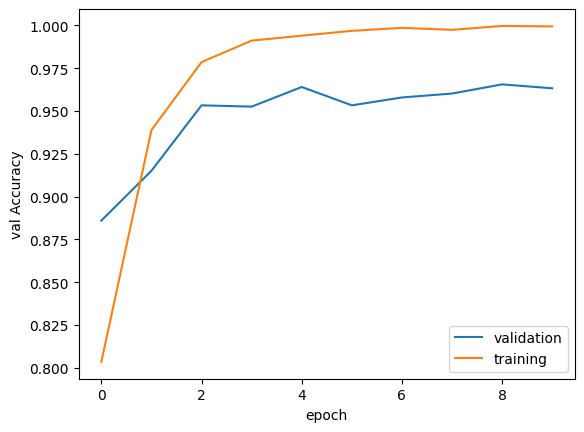

In [64]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_three_train, label='validation')
sns.lineplot(x='epoch', y='train Accuracy', data=batch_three_train, label='training')

The model did outperform all the previous models with a validation accuracy of around **96%**. 

<Axes: xlabel='epoch', ylabel='val loss'>

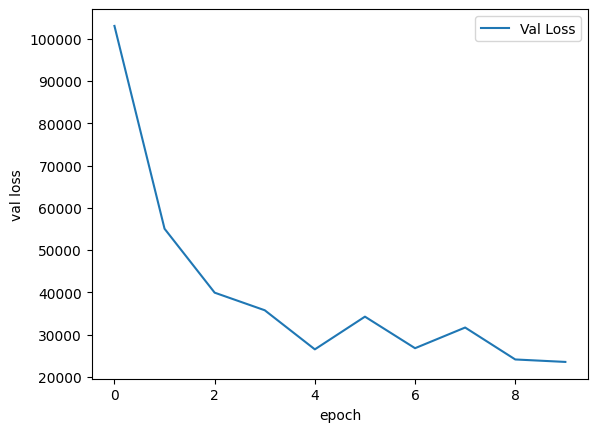

In [65]:
sns.lineplot(x='epoch', y='val loss', data=batch_three_train, label='Val Loss')

Now, we wanted to compare our model with a pre-trained model i.e vgg16.

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

Fine Tuning the model: Changing the output classes to 2 classes suitable for our case.

In [66]:
    model = models.vgg16(pretrained=True)
    #print list(list(model.classifier.children())[1].parameters())
    mod = list(model.classifier.children())
    mod.pop()
    mod.append(torch.nn.Linear(4096, 2)) #performing surgery by changing the output classes to 2
    new_classifier = torch.nn.Sequential(*mod)
    #print list(list(new_classifier.children())[1].parameters())
    model.classifier = new_classifier


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s] 


Training the new model with the updated network.

In [67]:
batch_one_train = train_simple_network(model, loss_func, train_loader, val_loader= test_loader,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/3500 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

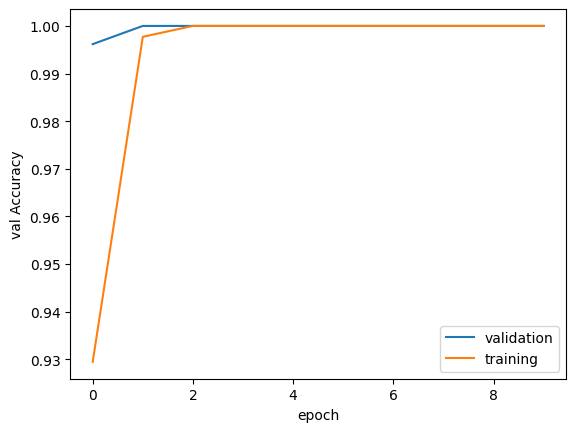

In [68]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='validation')
sns.lineplot(x='epoch', y='train Accuracy', data=batch_one_train, label='training')

The pre-trained model achieved a 100% validation accuracy after just 1 epoch.

<Axes: xlabel='epoch', ylabel='val loss'>

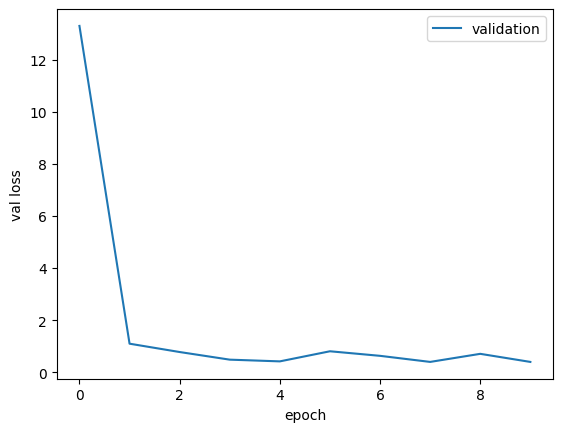

In [69]:
sns.lineplot(x='epoch', y='val loss', data=batch_one_train, label='validation')

### Conclusion

Although the models we designed performed well, the pre-trained model out-performed them. The constant and surging accuracy can possibly be attributed to the size of our dataset. This was a good learning experience that enlightened us to newer and efficicent techniques. An extension of this project could be using un-labelled data and trying to learn features to detect tumor. 